
Neural Networks
===============

Neural networks can be constructed using the ``torch.nn`` package.


A typical training procedure for a neural network is as follows:

- Define the neural network that has some learnable parameters (or
  weights)
- Iterate over a dataset of inputs
- Process input through the network
- Compute the loss (how far is the output from being correct)
- Propagate gradients back into the network’s parameters
- Update the weights of the network, typically using a simple update rule:
  ``weight = weight - learning_rate * gradient``

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print('CUDA is available. Training on GPU ...')
else:
    print('CUDA not available. Training on CPU ...')

CUDA not available. Training on CPU ...


### Load the data

We are using MINIST Dataset

In [2]:
# Define a transform the data
transform = transforms.Compose([transforms.ToTensor()])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

Define the network
------------------

Let’s define this network:



In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = nn.LogSoftmax(dim=1)(x)
        return x


net = Net()
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [18]:
# use GPU if available
if train_on_gpu:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [19]:
# Loss Function
criterion = nn.NLLLoss()

net.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [20]:
# optimizer 
from torch import optim
optimizer =  optim.SGD(net.parameters(), lr=0.003)

### Training the Network

Now we know how to use all the individual parts so it's time to see how they work together. Let's consider just one learning step before looping through all the data. The general process with PyTorch:

* Make a forward pass through the network
* Use the network output to calculate the loss
* Perform a backward pass through the network with loss.backward() to calculate the gradients
* Take a step with the optimizer to update the weights


In [21]:
epochs = 15
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    net.train()
    for images, labels in trainloader:
        # move tensors to GPU is CUDA is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        # Flatten Image
        images = images.view(images.shape[0], -1)
        # Clear the gradeints
        optimizer.zero_grad()
        
        # Forward pass, get our logits
        log_ps = net(images)
        # Calculate the loss with the logits and the labels
        loss = criterion(log_ps, labels)
        # Calculate the gradients
        loss.backward()
        # Update the weights
        optimizer.step()
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        net.eval()
        with torch.no_grad():
            for images, labels in testloader:
                # move tensors to GPU is CUDA is available
                if train_on_gpu:
                    images, labels = images.cuda(), labels.cuda()
                # Flatten Image
                images = images.view(images.shape[0], -1)
                log_ps = net(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        # print training/test statistics
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/15..  Training Loss: 2.104..  Test Loss: 1.629..  Test Accuracy: 0.617
Epoch: 2/15..  Training Loss: 1.013..  Test Loss: 0.644..  Test Accuracy: 0.830
Epoch: 3/15..  Training Loss: 0.544..  Test Loss: 0.456..  Test Accuracy: 0.874
Epoch: 4/15..  Training Loss: 0.433..  Test Loss: 0.388..  Test Accuracy: 0.890
Epoch: 5/15..  Training Loss: 0.384..  Test Loss: 0.354..  Test Accuracy: 0.898
Epoch: 6/15..  Training Loss: 0.356..  Test Loss: 0.330..  Test Accuracy: 0.905
Epoch: 7/15..  Training Loss: 0.335..  Test Loss: 0.315..  Test Accuracy: 0.908
Epoch: 8/15..  Training Loss: 0.318..  Test Loss: 0.302..  Test Accuracy: 0.913
Epoch: 9/15..  Training Loss: 0.305..  Test Loss: 0.290..  Test Accuracy: 0.918
Epoch: 10/15..  Training Loss: 0.293..  Test Loss: 0.278..  Test Accuracy: 0.921
Epoch: 11/15..  Training Loss: 0.282..  Test Loss: 0.270..  Test Accuracy: 0.922
Epoch: 12/15..  Training Loss: 0.272..  Test Loss: 0.262..  Test Accuracy: 0.925
Epoch: 13/15..  Training Loss: 0.263.

predicted number is: 6


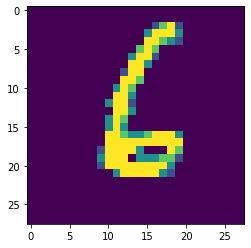

In [53]:
idx = 0
dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[idx].view(1, 784)

# Calculate the class probabilities (softmax) for img
ps = torch.exp(net(img))
print(f'predicted number is: {int(torch.argmax(ps))}')
plt.imshow(images[idx].view(28,28))
plt.show()

In [50]:
ps

tensor([[1.2010e-05, 2.8259e-07, 1.5704e-04, 9.9864e-01, 4.2095e-07, 8.8162e-04,
         1.7534e-10, 1.3995e-04, 1.3704e-04, 3.3386e-05]],
       grad_fn=<ExpBackward0>)

In [23]:
torch.argmax(ps)

tensor(9)

### CNN

In [22]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


cnn_net = CNN()
print(cnn_net)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [24]:
epochs = 15
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    cnn_net.train()
    for images, labels in trainloader:
        # move tensors to GPU is CUDA is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        # Flatten Image
#         images = images.view(images.shape[0], -1)
        # Clear the gradeints
        optimizer.zero_grad()
        
        # Forward pass, get our logits
        log_ps = cnn_net(images)
        # Calculate the loss with the logits and the labels
        loss = criterion(log_ps, labels)
        # Calculate the gradients
        loss.backward()
        # Update the weights
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        net.eval()
        with torch.no_grad():
            for images, labels in testloader:
                # move tensors to GPU is CUDA is available
                if train_on_gpu:
                    images, labels = images.cuda(), labels.cuda()
                # Flatten Image
#                 images = images.view(images.shape[0], -1)
                log_ps = cnn_net(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        # print training/test statistics
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

RuntimeError: size mismatch, m1: [32 x 400], m2: [576 x 120] at /opt/conda/conda-bld/pytorch_1573049308701/work/aten/src/TH/generic/THTensorMath.cpp:197